In [41]:

from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append(
    os.environ.get('WORK_DIR')) #type: ignore
sys.path.append(
    os.environ.get('DBASE_DIR')) #type: ignore
from dbase.DataAPI.ThetaData import * #type: ignore
from dbase.database.SQLHelpers import * #type: ignore
import pandas as pd
from EventDriven.data import HistoricTradeDataHandler
from EventDriven.event import *
from queue import Queue
from trade.backtester_.backtester_ import PTDataset, PTBacktester
import pandas_ta as ta
from trade.assets.Stock import Stock
from trade.backtester_.utils.WalkForwardUtils import prev_monday 
from trade.backtester_.strats import BBandsTrend2
from trade.backtester_.strats import MAStrat
import yfinance as yf
from datetime import datetime
from EventDriven.backtest import OptionSignalBacktest
from copy import deepcopy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
thetadata_start = '2021-01-01'

In [43]:
import json
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
key = 9
with open(f'../input/profitable_weights_{key}.json', 'r') as f:
    weights = json.load(f)
ttrades__ = pd.read_csv(f'../input/profitable_trades_{key}.csv').iloc[:, 1:]
ttrades__['Duration'] = ttrades__.Duration.apply(lambda x: int(x.split(' ')[0]))
# ttrades__ = ttrades__[ttrades__.Duration>0]
ttrades__#.Ticker.unique()

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,13.0,506.0,509.0,602.009658,549.460022,-683.145269,-0.087290,2022-01-04,2022-01-07,3,NFLX
1,53.0,506.0,510.0,151.538529,129.080002,-1190.301966,-0.148203,2022-01-04,2022-01-10,6,AMD
2,15.0,506.0,510.0,566.204785,529.289978,-553.722111,-0.065197,2022-01-04,2022-01-10,6,COST
3,36.0,506.0,510.0,397.904471,333.333344,-2324.560587,-0.162278,2022-01-04,2022-01-10,6,TSLA
4,71.0,506.0,516.0,183.269210,170.000000,-942.113903,-0.072403,2022-01-04,2022-01-19,15,AAPL
5,16.0,511.0,518.0,520.615788,481.920013,-619.132389,-0.074327,2022-01-11,2022-01-21,10,COST
6,72.0,517.0,553.0,167.564426,151.449997,-1160.238871,-0.096169,2022-01-20,2022-03-14,53,AAPL
7,1193.0,519.0,521.0,22.408155,23.240000,992.390903,0.037122,2022-01-24,2022-01-26,2,NVDA
8,16.0,519.0,592.0,477.214413,496.100006,302.169494,0.039575,2022-01-24,2022-05-09,105,COST
9,60.0,520.0,523.0,114.499348,101.550003,-776.960725,-0.113095,2022-01-25,2022-01-28,3,AMD


In [44]:
trades_ = ttrades__.copy()
trades_

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,Ticker
0,13.0,506.0,509.0,602.009658,549.460022,-683.145269,-0.087290,2022-01-04,2022-01-07,3,NFLX
1,53.0,506.0,510.0,151.538529,129.080002,-1190.301966,-0.148203,2022-01-04,2022-01-10,6,AMD
2,15.0,506.0,510.0,566.204785,529.289978,-553.722111,-0.065197,2022-01-04,2022-01-10,6,COST
3,36.0,506.0,510.0,397.904471,333.333344,-2324.560587,-0.162278,2022-01-04,2022-01-10,6,TSLA
4,71.0,506.0,516.0,183.269210,170.000000,-942.113903,-0.072403,2022-01-04,2022-01-19,15,AAPL
5,16.0,511.0,518.0,520.615788,481.920013,-619.132389,-0.074327,2022-01-11,2022-01-21,10,COST
6,72.0,517.0,553.0,167.564426,151.449997,-1160.238871,-0.096169,2022-01-20,2022-03-14,53,AAPL
7,1193.0,519.0,521.0,22.408155,23.240000,992.390903,0.037122,2022-01-24,2022-01-26,2,NVDA
8,16.0,519.0,592.0,477.214413,496.100006,302.169494,0.039575,2022-01-24,2022-05-09,105,COST
9,60.0,520.0,523.0,114.499348,101.550003,-776.960725,-0.113095,2022-01-25,2022-01-28,3,AMD


In [45]:
symbol_list = trades_.Ticker.unique()
untraded_symbols = [s for s in weights.keys() if s not in trades_.Ticker.unique()]
for s in untraded_symbols:
    weights.pop(s)
pd.Series(weights).sort_values(ascending=False)

NVDA    0.258200
TSLA    0.141689
AAPL    0.126342
COST    0.086172
NFLX    0.079848
AMD     0.078142
BA      0.063678
SBUX    0.062422
AMZN    0.057160
dtype: float64

In [46]:

from EventDriven.riskmanager import RiskManager, close_cache, spot_cache, chain_cache, oi_cache, LOOKBACKS, order_cache
from pandas.tseries.offsets import BDay

rm = RiskManager(None, None, 1000000)
rm.OrderPicker.liquidity_threshold = 2
rm.OrderPicker.lookback = 10
rm.OrderPicker.data_availability_threshold = 0.15
date, tick = '2023-07-05', 'AVGO'
date, tick = '2024-08-13', 'TSM'
start = (pd.to_datetime(date) - BDay(30)).strftime('%Y-%m-%d')
right = 'C'
order_settings = {'type': 'spread',
 'specifics': [{'direction': 'long',
   'rel_strike': .50,
   'dte': 210,
   'moneyness_width': 0.5},
  #  {'direction': 'short',
  # 'rel_strike': .60,
  # 'dte': 270,
  # 'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}



order =  rm.OrderPicker.get_order(tick, date, right, 2, order_settings)
order

{'result': 'SUCCESSFUL',
 'data': {'long': ['TSM20250321C280'],
  'trade_id': '&L:TSM20250321C280',
  'close': 1.515}}

In [47]:
max_cash = {}
cash = 20_000
for s, w in weights.items():
    if w * cash > 200:
        max_cash[s] = 2
    elif w * cash > 100:
        max_cash[s] = 1
    else:
        max_cash[s] = 0.5
max_cash

{'NVDA': 2,
 'TSLA': 2,
 'AMD': 2,
 'AAPL': 2,
 'NFLX': 2,
 'COST': 2,
 'AMZN': 2,
 'BA': 2,
 'SBUX': 2}

In [130]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo

evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash)

In [131]:
evb_backtest.portfolio.initial_capital

20000.0

In [132]:
w_map = {x: w  * 0.85 for x, w in weights.items()} ## 75% of the weights for each stock
evb_backtest.portfolio.weight_map = w_map
evb_backtest.portfolio.weight_map
evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
evb_backtest.portfolio.order_settings = {'type': 'naked',
 'specifics': [{'direction': 'long',
   'rel_strike': .850,
   'dte': 365,
   'moneyness_width': 0.35},
   {'direction': 'short',
  'rel_strike': .60,
  'dte': 365,
  'moneyness_width': 0.35}
],
 'name': 'vertical_spread'}


evb_backtest.portfolio.max_contract_price = max_cash
evb_backtest.executor.commission_rate = 0.65/100
evb_backtest.executor.commission_rate
evb_backtest.executor.max_slippage_pct = 0.075
evb_backtest.portfolio.roll_map = 30
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price
evb_backtest.portfolio.roll_map
evb_backtest.portfolio.allocated_cash_map
evb_backtest.portfolio.max_contract_price
evb_backtest.portfolio.dte_reduction_factor = 60


In [133]:
for key  in max_cash:
    if max_cash[key]*100 > evb_backtest.portfolio.allocated_cash_map[key]:
        print(key, max_cash[key]*100, evb_backtest.portfolio.allocated_cash_map[key])

In [134]:
pd.options.display.max_rows = 15
pd.options.display.max_columns = 15
signals = evb_backtest.bars.signal_df
# series = signals.set_index('Date')['MSFT']
# series[series != 0]
signals

,Date,NFLX,AMD,COST,TSLA,AAPL,NVDA,AMZN,SBUX,BA
0,2022-01-04,1,1,1,1,1,0,0,0,0
1,2022-01-05,0,0,0,0,0,0,0,0,0
2,2022-01-06,0,0,0,0,0,0,0,0,0
3,2022-01-07,-1,0,0,0,0,0,0,0,0
4,2022-01-10,0,-1,-1,-1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
254,2022-12-26,0,0,0,0,0,0,0,0,0
255,2022-12-27,0,0,0,0,0,0,0,0,0
256,2022-12-28,0,0,0,0,0,0,0,0,0
257,2022-12-29,0,0,0,0,0,0,0,0,0


In [135]:
signals[['Date','COST']].head(20)

,Date,COST
0,2022-01-04,1
1,2022-01-05,0
2,2022-01-06,0
3,2022-01-07,0
4,2022-01-10,-1
...,...,...
15,2022-01-25,0
16,2022-01-26,0
17,2022-01-27,0
18,2022-01-28,0


In [136]:
signals_df = deepcopy(signals).set_index('Date')
signals_df[signals_df!=-1].sum().sum()

25.0

## Problems:

- Current Problem: SELL Signal and Buy Signal are put right next to each other in the queue. Whereas, it is meant to be Sell Signal -> Order Event -> Fill Event -> Buy Signal -> Order Event -> Fill Event

Solution:
- Use a tuple of action ```python['CLOSE', 'OPEN']```
- Put first action into queue and return ffunctionality to backtester. Backtester then handles all corresponding sequence.
- Do the same for action two.

In [137]:
import cProfile
import pstats
import io

profiler = cProfile.Profile()
profiler.enable()
#run backtest

evb_backtest.run()
profiler.disable()
stream = io.StringIO()
stats = pstats.Stats(profiler, stream=stream).sort_stats('cumulative')

Processing event: MARKET
Processing event: SIGNAL
Buy Details
Position: {'long': ['NFLX20230120C1000'], 'short': ['NFLX20230120C1050'], 'trade_id': '&L:NFLX20230120C1000&S:NFLX20230120C1050', 'close': 1.674999999999999}, Date: 2022-01-04, Signal: SignalEvent type:LONG, symbol=NFLX, date:2022-01-04 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:NFLX20220104LONG
Max Contract Price: 2, Cash at Hand: 12.216806909481978
Cash at Hand 12.216806909481978 Close 1.674999999999999
Processing event: SIGNAL
Buy Details
Position: {'long': ['AMD20230120C200'], 'short': ['AMD20230120C210'], 'trade_id': '&L:AMD20230120C200&S:AMD20230120C210', 'close': 1.8499999999999996}, Date: 2022-01-04, Signal: SignalEvent type:LONG, symbol=AMD, date:2022-01-04 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:AMD20220104LONG
Max Contract Price: 2, Cash at Hand: 11.955693809672423
Cash at Hand 11.955693809672423 Close 1.8499999999999996
Processing event: SIGNAL
Not generating order

In [138]:
pd.set_option('display.max_rows', 100)
transactions=evb_backtest.portfolio.transactions
transactions[transactions.symbol=='COST']

,signal_id,datetime,symbol,direction,cash_before,cash_after
4,COST20220104LONG,2022-01-04,COST,BUY,1464.916744,384.458562
7,COST20220104LONG,2022-01-10,COST,SELL,384.458562,965.098063
9,COST20220111LONG,2022-01-11,COST,BUY,965.098063,159.491906
12,COST20220111LONG,2022-01-21,COST,SELL,159.491906,29.036407


In [139]:
from EventDriven.execution import exec_cache
idx = 10
buys = [x  for x in exec_cache['fill'].values() if x.direction == 'BUY']
buy1 = buys[idx]
print("Buy")
print(buy1.datetime,buy1.fill_cost/buy1.quantity, buy1.market_value)

sells = [x  for x in exec_cache['fill'].values() if x.direction == 'SELL']
sell1 = sells[idx]
print("Sell")
print(sell1.datetime,sell1.fill_cost/sell1.quantity, sell1.market_value, len(exec_cache['fill']))


Buy
2022-02-01 00:00:00 2.0511720093290995 34.648924158594696
Sell
2022-03-14 00:00:00 0.6399076875527588 3.917446125316553 82


In [140]:
tsla_buys = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'BUY']
tsla_sells = [x  for x in exec_cache['fill'].values() if x.symbol == 'TSLA' and x.direction == 'SELL']
tsla_buys, tsla_sells

([<EventDriven.event.FillEvent at 0x136a8a350>,
  <EventDriven.event.FillEvent at 0x141ca2310>])

In [147]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50
trades = evb_backtest.portfolio._trades.copy()#
len(trades)
# len(trades['SignalID'].unique())
trades[['Positions','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']]
trades[['SignalID', 'Ticker', 'ReturnPct', 'Positions', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue']]

,SignalID,Ticker,ReturnPct,Positions,EntryTime,ExitTime,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue
0,NFLX20220104LONG,NFLX,-0.278311,&L:NFLX20230120C1000&S:NFLX20230120C1050,2022-01-04,2022-01-07,181.066172,130.673376,1078.597034,791.840257
1,AMD20220104LONG,AMD,-0.362432,&L:AMD20230120C200&S:AMD20230120C210,2022-01-04,2022-01-10,197.499728,125.919429,1177.198370,763.316571
2,TSLA20220104LONG,TSLA,-0.138963,&L:TSLA20230120C2100&S:TSLA20230120C2125,2022-01-04,2022-01-10,207.666037,178.808100,2063.660375,1801.080996
3,AAPL20220104LONG,AAPL,-0.414465,&L:AAPL20230120C240&S:AAPL20230120C260,2022-01-04,2022-01-19,200.964984,117.671958,1796.984855,1070.747618
4,COST20220104LONG,COST,-0.462599,&L:COST20230120C680&S:COST20230120C700,2022-01-04,2022-01-10,360.152727,193.546500,1076.558182,584.539501
5,COST20220111LONG,COST,-1.161935,&L:COST20230120C680&S:COST20230120C700,2022-01-11,2022-01-21,201.401539,-32.613875,800.406156,-125.255499
6,AAPL20220120LONG,AAPL,-0.685846,&L:AAPL20230120C195&S:AAPL20230120C200,2022-01-20,2022-03-14,203.692120,63.990769,1214.352718,391.744613
7,NVDA20220124LONG,NVDA,-0.121898,&L:NVDA20230120C430&S:NVDA20230120C475,2022-01-24,2022-01-26,206.807421,181.597986,3904.640992,3475.061726
8,AMD20220125LONG,AMD,-0.342206,&L:AMD20230120C195&S:AMD20230120C230,2022-01-25,2022-01-28,207.512458,136.500433,618.637373,413.401300
9,NVDA20220201LONG,NVDA,-0.345706,&L:NVDA20230120C360&S:NVDA20230120C375,2022-02-01,2022-02-23,205.117201,134.206901,3464.892416,2303.617313


allocated_key NVDA
NVDA =  SIG2, SIG1,
Both sigs have BUY SELL


NVDA
|
SIG2      SIG1
|
SELL BUY  SELL BUY

NVDA
|
SIG1       SIG2
|            |
SELL BUY   SELL BUY

In [142]:
reasons = {
    x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
}

for v in (evb_backtest.portfolio.unprocessed_signals):
    reasons[v['reason']] += 1
    print(v) 
reasons

{'type': 'SIGNAL', 'symbol': 'COST', 'datetime': Timestamp('2022-01-24 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'COST20220124LONG', 'max_contract_price': None, 'order_settings': None, 'reason': 'MAX_PRICE_TOO_LOW'}
{'type': 'SIGNAL', 'symbol': 'AMZN', 'datetime': Timestamp('2022-03-29 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'AMZN20220329LONG', 'max_contract_price': 8.599633919999999, 'order_settings': None, 'reason': 'MAX_PRICE_TOO_LOW'}
{'type': 'SIGNAL', 'symbol': 'COST', 'datetime': Timestamp('2022-07-29 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'COST20220729LONG', 'max_contract_price': None, 'order_settings': None, 'reason': 'MAX_PRICE_TOO_LOW'}
{'type': 'SIGNAL', 'symbol': 'COST', 'datetime': Timestamp('2022-11-22 00:00:00'), 'signal_type': 'LONG', 'signal_id': 'COST20221122LONG', 'max_contract_price': None, 'order_settings': None, 'reason': 'MAX_PRICE_TOO_LOW'}


{'MAX_PRICE_TOO_LOW': 4}

<Axes: xlabel='datetime'>

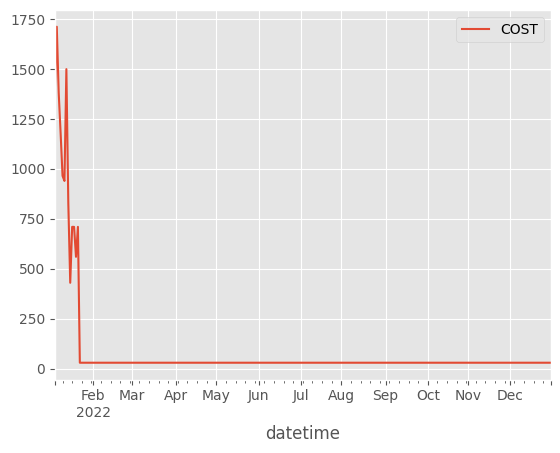

In [143]:
evb_backtest.portfolio._equity.plot(y = 'COST')

In [144]:
evb_backtest.portfolio.plot_portfolio()

In [128]:
evb_backtest.portfolio.aggregate()

Start                                                    2022-01-04 00:00:00
End                                                      2022-12-30 00:00:00
Duration                                                   360 days 00:00:00
Exposure Time [%]                                                      73.75
Equity Final [$]                                                    11434.37
Equity Peak [$]                                                 19605.172653
Return [%]                                                        -41.676763
Buy & Hold Return [%]                                             -42.017088
CAGR [%]                                                          -42.111884
Volatility Ann. [%]                                                43.840687
Sharpe Ratio                                                       -1.028319
Sortino Ratio                                                      -1.056012
Skew                                                                0.799218

,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2022-01-04,2.85,2.10,3.55,3.25,-100,50,1.75,39,4.95,3.350,3.042473
2022-01-05,4.10,3.80,5.10,4.75,-27,-41,3.50,61,5.35,4.425,6.236236
2022-01-06,4.41,4.14,4.41,4.19,-6,17,3.30,1,3.35,3.325,3.304925
2022-01-07,1.24,1.62,2.92,2.80,-7,55,2.40,4,2.90,2.650,2.180994
2022-01-10,1.99,2.46,2.36,1.98,-116,-33,1.85,0,2.15,2.000,2.047370
2022-01-11,1.91,1.64,1.91,2.01,-65,10,1.90,-2,2.00,1.950,1.797496
2022-01-12,3.50,2.70,3.65,3.59,-27,26,1.60,139,5.10,3.350,4.314402
2022-01-13,-9.44,-9.44,-9.22,-9.22,-3,151,1.45,2,1.90,1.675,0.925024
2022-01-14,-8.75,-8.75,-8.10,-8.10,-2,191,-0.50,44,1.85,0.675,-0.033739


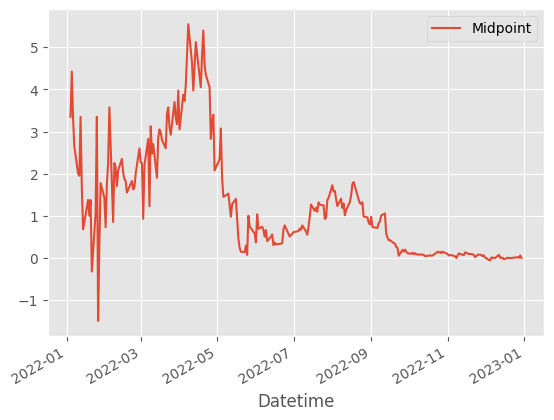

In [162]:
#&L:COST20230120C680&S:COST20230120C700
# 9	2022-01-11	COST	BUY	989.300187	165.485214
# 12	2022-01-21	COST	SELL	165.485214	33.494091
# &L:AAPL20230120C240&S:AAPL20230120C260	2022-01-04	2022-01-19
price_data = evb_backtest.portfolio.options_data['COST20230120C680'] - evb_backtest.portfolio.options_data['COST20230120C700']
price_data.plot(y = 'Midpoint')
price_data[(price_data.index >= '2022-01-04') & (price_data.index <= '2022-01-25')]
# price_data[price_data.index.isin(['2022-01-04', '2022-01-21'])]

In [156]:
price_data

,Open,High,Low,Close,Volume,Bid_size,CloseBid,Ask_size,CloseAsk,Midpoint,Weighted_midpoint
Datetime,,,,,,,,,,,
2022-01-04,2.85,2.10,3.55,3.25,-100,50,1.75,39,4.95,3.350,3.042473
2022-01-05,4.10,3.80,5.10,4.75,-27,-41,3.50,61,5.35,4.425,6.236236
2022-01-06,4.41,4.14,4.41,4.19,-6,17,3.30,1,3.35,3.325,3.304925
2022-01-07,1.24,1.62,2.92,2.80,-7,55,2.40,4,2.90,2.650,2.180994
2022-01-10,1.99,2.46,2.36,1.98,-116,-33,1.85,0,2.15,2.000,2.047370
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.00,0.00,0.00,0.00,0,0,0.00,0,0.00,0.000,0.000000
2022-12-27,-0.01,-0.01,-0.01,-0.01,-10,0,0.00,3,0.03,0.015,0.030000
2022-12-28,0.00,0.00,0.00,0.00,0,0,0.00,-4,0.00,0.000,0.000000


In [152]:
(1.235/1.950)-1

-0.3666666666666666

In [63]:

pd.set_option('display.max_rows', 10000)
evb_backtest.portfolio.get_all_positions()

long                short  \
datetime   symbol                                             
2022-01-04 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-05 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-06 NFLX     [NFLX20220916C800]   [NFLX20220916C900]   
           AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-07 AMD       [AMD20220916C150]    [AMD20220916C155]   
           COST     [COST20230120C680]   [COST20230120C700]   
           TSLA    [TSLA20220916C2025]  [TSLA20220916C2050]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-10 AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-11 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-12 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-13 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-14 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-17 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-18 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20220916C210]   [AAPL20220916C220]   
2022-01-19 COST     [COST20230120C680]   [COST20230120C700]   
2022-01-20 COST     [COST20230120C680]   [COST20230120C700]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-21 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-24 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-25 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C430]   [NVDA20230120C475]   
2022-01-26 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-27 AMD       [AMD20230120C195]    [AMD20230120C230]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-28 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-01-31 AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
2022-02-01 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-02 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-03 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-04 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
2022-02-07 AMD       [AMD20230120C175]    [AMD20230120C190]   
           AAPL     [AAPL20221118C200]   [AAPL20221118C210]   
           NVDA     [NVDA20230120C360]   [NVDA20230120C375]   
20

In [64]:


""""
Why do these two return weird stuff after run?
    current_weighted_holdings
    current_positions

I can't reconcile the cost with the data (NVM, haha)

"""
# evb_backtest.portfolio.all_positions

'"\nWhy do these two return weird stuff after run?\n    current_weighted_holdings\n    current_positions\n\nI can\'t reconcile the cost with the data (NVM, haha)\n\n'

In [65]:
order_cache['2024-01-03']

KeyError: '2024-01-03'

## Extend for  get_port_stats
- Buy & Hold
- Dates
- Trades
- _strategy in Aggregate
- The function

In [89]:
evb_backtest.trades.to_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/output/profitable_trades_options_{key}.csv')

AttributeError: 'OptionSignalBacktest' object has no attribute 'trades'